# Speculative Decoding

This tutorial demonstrates how to gain a efficiency speedup by enabling the speculative decoding in LLM serving. We take vLLM, one of the most common-used open-source LLM frameworks, as the serving engine. We conduct all the benchmark and analysis on AMD MI300X GPUs and AMD software stacks. For a basic understanding and usage of speculative decoding, please refer to our previous blog: [vLLM Speculative Decoding](https://www.amd.com/en/developer/resources/technical-articles/vllm-x-amd-highly-efficient-llm-inference-on-amd-instinct-mi300x-gpus.html). 

Overall, vLLM achieves an up to 2.31x speedup when enabled with speculative decoding. In this tutorial, we take Llama 3.1 70B as the base model and Llama 3.1 1B as the draft model, comparing their serving performance without and with speculative decoding enabled. We provide detailed steps to reproduce the performance gain on AMD MI300X GPUs.



## Prerequisites
This tutorial was developed and tested using the following setup.

### Operating system

* **Ubuntu 22.04**: Ensure your system is running Ubuntu version 22.04.

### Hardware
- **AMD Instinct™ GPU(s)**: This tutorial has been tested on AMD Instinct MI300X GPUs. Ensure you are using an AMD Instinct GPU or compatible hardware with ROCm support and that your system meets the [official requirements](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/reference/system-requirements.html).


### Software
* **ROCm 6.2+**: Install and verify ROCm by following the [ROCm install guide](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/install/quick-start.html). After installation, confirm your setup using:

``` bash
rocm-smi
```

This command lists your AMD GPUs with relevant details, similar to the image below.

   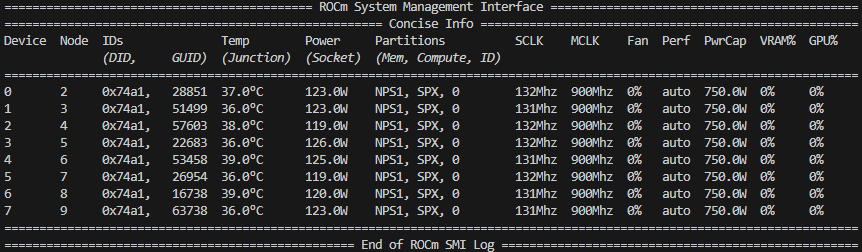


* **Docker**: Ensure Docker is installed and configured correctly. Follow the Docker installation guide for your operating system.

   **Note**: Ensure the Docker permissions are correctly configured. To configure permissions to allow non-root access, run the following commands:

   ``` bash
   sudo usermod -aG docker $USER
   newgrp docker
   ```

   Verify Docker is working correctly:

   ``` bash
   docker run hello-world
   ```

### Hugging Face API access

* Obtain an API token from [Hugging Face](https://huggingface.co) for downloading models.
* Ensure the Hugging Face API token has the necessary permissions and approval to access the [Meta Llama checkpoints](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct).

### Data preparation

* This tutorial uses a sample dataset from Hugging Face, which is prepared during the setup steps.


## Preparing the serving environment

### 1. Pull the Docker image

Ensure your system meets the [system requirements](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/reference/system-requirements.html).

Pull the Docker image required for this tutorial:

``` bash
docker pull rocm/vllm:latest
```

### 2. Launch the Docker container

Launch the Docker container and map the necessary directories. Replace `/path/to/notebooks` with the full path to the directory on your host machine where these notebooks are stored.

``` bash
docker run -it --rm \
  --network=host \
  --ipc=host \
  --privileged \
  --cap-add=CAP_SYS_ADMIN \
  --device=/dev/kfd \
  --device=/dev/dri \
  --device=/dev/mem \
  --group-add render \
  --cap-add=SYS_PTRACE \
  --security-opt seccomp=unconfined \
  --name vllm_spec_dec \
  -v $MODEL_PATH:/models \
  -v $WORK_PATH:/work \
  rocm/vllm:latest
```

**Note**: This command mounts `$MODEL_PATH` to the `/models` directory in the container and `$WORK_PATH` to the `/work` directory in the container. Ensure the notebook file is either copied to your `$WORK_PATH` directory before running the Docker command or uploaded into the Jupyter Notebook environment after it starts. Save the token or URL provided in the terminal output to access the notebook from your web browser. You can download this notebook from the [AI Developer Hub GitHub repository](https://github.com/ROCm/gpuaidev).


### 3. Install and launch Jupyter

Inside the Docker container, install Jupyter using the following command:

``` bash
pip install jupyter
```

Start the Jupyter server:

``` bash
jupyter-lab --ip=0.0.0.0 --port=8888 --no-browser --allow-root
```

**Note**: Ensure port `8888` is not already in use on your system before running the above command. If it is, you can specify a different port by replacing `--port=8888` with another port number, for example, `--port=8890`.


### 4. Provide your Hugging Face token

You'll require a Hugging Face API token to access Llama-3.1. Generate your token at [Hugging Face Tokens](https://huggingface.co/settings/tokens) and request access for [Llama-3.1 8B](https://huggingface.co/meta-llama/Meta-Llama-3.1-8B-Instruct). Tokens typically start with "hf_". 

There are two ways to set up the Hugging Face token: by running a python script or by running a bash command.

By running a python script, you can run the following interactive block in your Jupyter notebook to set up the token:

**Note**: Uncheck the "Add token as Git credential" option.

This command lists your AMD GPUs with relevant details, similar to the image below.

   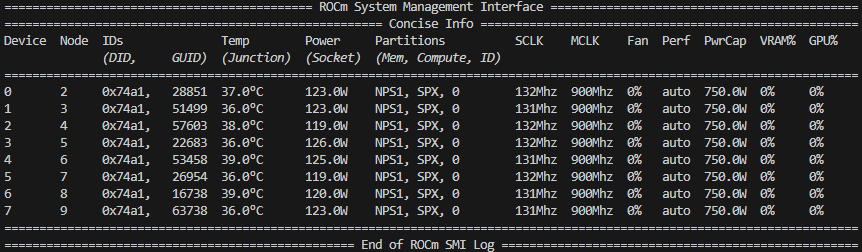


* **Docker**: Ensure Docker is installed and configured correctly. Follow the Docker installation guide for your operating system.

   **Note**: Ensure the Docker permissions are correctly configured. To configure permissions to allow non-root access, run the following commands:

   ``` bash
   sudo usermod -aG docker $USER
   newgrp docker
   ```

   Verify Docker is working correctly:

   ``` bash
   docker run hello-world
   ```

### Hugging Face API access

* Obtain an API token from [Hugging Face](https://huggingface.co) for downloading models.
* Ensure the Hugging Face API token has the necessary permissions and approval to access the [Meta Llama checkpoints](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct).

### Data preparation

* This tutorial uses a sample dataset from Hugging Face, which is prepared during the setup steps.


## Preparing the serving environment

### 1. Pull the Docker image

Ensure your system meets the [system requirements](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/reference/system-requirements.html).

Pull the Docker image required for this tutorial:

``` bash
docker pull rocm/vllm:rocm6.3.1_mi300_ubuntu22.04_py3.12_vllm_0.6.6
```

### 2. Launch the Docker container

Launch the Docker container and map the necessary directories. Replace `/path/to/notebooks` with the full path to the directory on your host machine where these notebooks are stored.

``` bash
docker run -it --rm \ 
  --ipc=host \
  --network=host \
  --privileged \
  --cap-add=CAP_SYS_ADMIN \
  --device=/dev/kfd \
  --device=/dev/dri \
  --device=/dev/mem \
  --group-add render \
  --cap-add=SYS_PTRACE \
  --security-opt seccomp=unconfined \
  --name vllm_spec_dec \
  -v $MODEL_PATH:/models \
  -v $WORK_PATH:/work \
  rocm/vllm:rocm6.3.1_mi300_ubuntu22.04_py3.12_vllm_0.6.6
```

**Note**: This command mounts `$MODEL_PATH` to the `/models` directory in the container and `$WORK_PATH` to the `/work` directory in the container. Ensure the notebook file is either copied to your `$WORK_PATH` directory before running the Docker command or uploaded into the Jupyter Notebook environment after it starts. Save the token or URL provided in the terminal output to access the notebook from your web browser. You can download this notebook from the [AI Developer Hub GitHub repository](https://github.com/ROCm/gpuaidev).


### 3. Install and launch Jupyter

Inside the Docker container, install Jupyter using the following command:

``` bash
pip install jupyter
```

Start the Jupyter server:

``` bash
jupyter-lab --ip=0.0.0.0 --port=8888 --no-browser --allow-root
```

**Note**: Ensure port `8888` is not already in use on your system before running the above command. If it is, you can specify a different port by replacing `--port=8888` with another port number, for example, `--port=8890`.


### 4. Provide your Hugging Face token

You'll require a Hugging Face API token to access Llama-3.1. Generate your token at [Hugging Face Tokens](https://huggingface.co/settings/tokens) and request access for [Llama-3.1 8B](https://huggingface.co/meta-llama/Meta-Llama-3.1-8B-Instruct). Tokens typically start with "hf_". 

There are two ways to set up the Hugging Face token: by running a python script or by running a bash command.

By running a python script, you can run the following interactive block in your Jupyter notebook to set up the token:

**Note**: Uncheck the "Add token as Git credential" option.

In [1]:
from huggingface_hub import notebook_login, HfApi

# Prompt the user to log in
notebook_login()

Verify that your token was accepted correctly:

In [2]:
from huggingface_hub import HfApi

try:
    api = HfApi()
    user_info = api.whoami()
    print(f"Token validated successfully! Logged in as: {user_info['name']}")
except Exception as e:
    print(f"Token validation failed. Error: {e}")

Token validated successfully! Logged in as: Chang0709


## Downloading the Model Weights [Optional]

You can download the model weights in `\models` in advance, by using the commands below. In this tutorial, we use AMD-optimized Llama 3.1 70B as the base model and Llama 3.1 1B as the speculative draft model.
**Note**: This step is optional. If you choose to skip it, the models used in the LLM serving will be automatically downloaded when the serving process starts, based on your specified commands.

In [5]:
# Download Llama 3.1 70B Instruct FP8 KV model weights in local
!huggingface-cli download \
  --resume-download \
  --local-dir-use-symlinks False \
  amd/Llama-3.1-70B-Instruct-FP8-KV \
  --local-dir /models/amd--Llama-3.1-70B-Instruct-FP8-KV

# Download Llama 3.1 1B Instruct FP8 KV model weights in local
!huggingface-cli download \
  --resume-download \
  --local-dir-use-symlinks False \
  amd/Llama-3.2-1B-Instruct-FP8-KV \
  --local-dir /models/amd--Llama-3.2-1B-Instruct-FP8-KV

/usr/local/lib/python3.12/dist-packages/huggingface_hub/commands/download.py:139: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Fetching 26 files: 100%|██████████████████████| 26/26 [00:00<00:00, 1291.24it/s]
/models/amd--Llama-3.1-70B-Instruct-FP8-KV
/usr/local/lib/python3.12/dist-packages/huggingface_hub/commands/download.py:139: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Down

## Starting the serving
In this tutorial, we use the online serving mode of vLLM to compare the performance of disabling and enabling the speculative decoding.

Use the command below to start the server without speculative decoding enabled, and modify the port when 8001 is in use:

In [6]:
!PYTORCH_TUNABLEOP_ENABLED=0 PYTORCH_TUNABLEOP_TUNING=0 PYTORCH_TUNABLEOP_MAX_TUNING_DURATION_MS=100 PYTORCH_TUNABLEOP_MAX_WARMUP_DURATION_MS=10 PYTORCH_TUNABLEOP_ROTATING_BUFFER_SIZE=1024 PYTORCH_TUNABLEOP_FILENAME=afo_tune_device_%d_full.csv HIP_FORCE_DEV_KERNARG=1 VLLM_USE_ROCM_CUSTOM_PAGED_ATTN=1 VLLM_INSTALL_PUNICA_KERNELS=1 TOKENIZERS_PARALLELISM=false RAY_EXPERIMENTAL_NOSET_ROCR_VISIBLE_DEVICES=1 NCCL_MIN_NCHANNELS=112 VLLM_USE_TRITON_FLASH_ATTN=0 VLLM_FP8_PADDING=1 VLLM_FP8_ACT_PADDING=1 VLLM_FP8_WEIGHT_PADDING=1 VLLM_FP8_REDUCE_CONV=1 \
vllm serve /models/amd--Llama-3.1-70B-Instruct-FP8-KV \
  --swap-space 16 \
  --disable-log-requests \
  --tensor-parallel-size 1 \
  --distributed-executor-backend mp \
  --dtype float16 \
  --quantization fp8 \
  --kv-cache-dtype fp8 \
  --enable-chunked-prefill=False \
  --max-num-seqs 300 \
  --port 8001


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]
INFO 04-23 14:58:50 __init__.py:179] Automatically detected platform rocm.
WARNING 04-23 14:58:50 rocm.py:34] `fork` method is not supported by ROCm. VLLM_WORKER_MULTIPROC_METHOD is overridden to `spawn` instead.
INFO 04-23 14:58:51 api_server.py:768] vLLM API server version 0.6.7.dev220+g84f5d47b
INFO 04-23 14:58:51 api_server.py:769] args: Namespace(subparser='serve', model_tag='/models/amd--Llama-3.1-70B-Instruct-FP8-KV', config='', host=None, port=8001, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key=None, lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role='assistant', ssl_keyfile=None, ssl_certfi

## Setting the client

After starting the server, we should start a client to send out requests. For the client, we use the SGLang docker image, lmsysorg/sglang:v0.4.1.post4-rocm620. Please turn on another terminal in your raw environment, initialize the client docker container using the command as below:

``` bash
docker run -it --rm \
  --ipc=host \
  --network=host \
  --privileged \
  --cap-add=CAP_SYS_ADMIN \
  --device=/dev/kfd \
  --device=/dev/dri \
  --device=/dev/mem  \
  --group-add render \
  --cap-add=SYS_PTRACE \
  --security-opt seccomp=unconfined \
  --shm-size=192g \
  --name spec_dec_client \
  -v $MODEL_PATH:/models \
  -v $WORK_PATH:/work \
  lmsysorg/sglang:v0.4.1.post4-rocm620
```

**Note**: Same as the command of starting the server, please modify `$MODEL_PATH` and `$WORK_PATH` corresponding to your actual model directory and workspace.

In the client container, you can benchmark the performance using a command as below:

``` bash
python3 -m sglang.bench_serving \ 
  --backend vllm \
  --dataset-name random \
  --num-prompt 500 \
  --request-rate 1.0 \
  --random-input 8192 \
  --random-output 256 > vllm_base_log
```

After running the client command, there is a log file named as "vllm_base_log" generated.

## Enabling speculative decoding in serving

Before running the cell below, please stop the previous cell where the server without speculative decoding enabled was running.
Use the command to start the server with speculative decoding enabled, and modify the port when 8001 is in use:

In [ ]:
!PYTORCH_TUNABLEOP_ENABLED=0 PYTORCH_TUNABLEOP_TUNING=0 PYTORCH_TUNABLEOP_MAX_TUNING_DURATION_MS=100 PYTORCH_TUNABLEOP_MAX_WARMUP_DURATION_MS=10 PYTORCH_TUNABLEOP_ROTATING_BUFFER_SIZE=1024 PYTORCH_TUNABLEOP_FILENAME=afo_tune_device_%d_full.csv HIP_FORCE_DEV_KERNARG=1 VLLM_USE_ROCM_CUSTOM_PAGED_ATTN=1 VLLM_INSTALL_PUNICA_KERNELS=1 TOKENIZERS_PARALLELISM=false RAY_EXPERIMENTAL_NOSET_ROCR_VISIBLE_DEVICES=1 NCCL_MIN_NCHANNELS=112 VLLM_USE_TRITON_FLASH_ATTN=0 VLLM_FP8_PADDING=1 VLLM_FP8_ACT_PADDING=1 VLLM_FP8_WEIGHT_PADDING=1 VLLM_FP8_REDUCE_CONV=1 \
vllm serve /models/amd--Llama-3.1-70B-Instruct-FP8-KV \ 
  --swap-space 16 \ 
  --disable-log-requests \
  --tensor-parallel-size 8 \
  --distributed-executor-backend mp \ 
  --dtype float16 \
  --quantization fp8 \
  --kv-cache-dtype fp8 \
  --enable-chunked-prefill=False \
  --max-num-seqs 300 \
  --port 8001 \
  --speculative-model /models/amd--Llama-3.2-1B-Instruct-FP8-KV \
  --num_speculative_tokens 5  \
  --speculative-model-quantization fp8

## Sending requests using the same client

After starting the server, we also use the same client docker container `spec_dec_client` to send out requests. For the client container, we use the docker image of SGLang, lmsysorg/sglang:v0.4.1.post4-rocm620.

In the terminal, use the command below to send requests:
``` bash
python3 -m sglang.bench_serving \ 
  --backend vllm \
  --dataset-name random \
  --num-prompt 500 \
  --request-rate 1.0 \
  --random-input 8192 \
  --random-output 256 > vllm_spec_dec_log
```

To explore more thoroughly of speculative decoding, you can modify the value of each parameter, e.g., `request-rate`, in the above command to observe the performance change. For more information, you can refer to the ablation study in our public blog, [Speculative Decoding - Deep Dive](https://rocm.blogs.amd.com/software-tools-optimization/speculative-decoding---deep-dive/README.html).